# Build Figures for SHINE 2017 Poster
Some figures for my poster at SHINE 2017. Use reduced data from my Loops Workshop talk.

In [1]:
import os
import glob

import numpy as np
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d,splev,splrep
from scipy.ndimage import map_coordinates,gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.ticker import MaxNLocator
import seaborn.apionly as sns
import astropy.units as u
import astropy.constants as const
from sunpy.map import Map,GenericMap
from ChiantiPy.tools import filters as ch_filters

import synthesizAR
from synthesizAR.instruments import InstrumentSDOAIA,InstrumentHinodeEIS
from synthesizAR.util import EISCube,EMCube
from synthesizAR.atomic import EmissionModel
from synthesizAR.model_ext import power_law_transform

sns.set_palette('deep')

%matplotlib inline

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


 using cli
 using CLI for selections
 reading chiantirc file


In [2]:
frequencies = [250,750,2500,5000]

## Forward Modeling

## Heating Model

In [3]:
event_energies = {'{}'.format(freq):[] for freq in frequencies}
event_wait_times = {'{}'.format(freq):[] for freq in frequencies}

In [4]:
for freq in frequencies:
    if type(freq) == int:
        field = synthesizAR.Skeleton.restore('/data/datadrive1/ar_forward_modeling/systematic_ar_study/noaa1109_tn{}/field_checkpoint/'.format(freq))
    else:
        field = synthesizAR.Skeleton.restore('/data/datadrive2/ar_viz/systematic_ar_study/noaa1109_tn750-ion/field_checkpoint/')
    for loop in field.loops:
        num_events = len(loop.hydro_configuration['heating']['events'])
        tmp_event_energies = []
        for i,event in enumerate(loop.hydro_configuration['heating']['events']):
            if i > 0:
                event_wait_times['{}'.format(freq)].append(event['event']['rise_start'] 
                                        - loop.hydro_configuration['heating']['events'][i-1]['event']['rise_end'])
            tmp_event_energies.append(event['event']['magnitude'])
            event_energies['{}'.format(freq)].append(event['event']['magnitude'])

No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-07-18 16:32:43,357 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-07-18 16:32:43,358 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-07-18 16:32:43,359 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017-07-18 16:32:43,360 Parameters: domain_right_edge         = [  4.35656994e+10   3.67056887e+10   3.54274434e+10]
yt : [INFO     ] 2017-07-18 16:32:43,361 Parameters: cosmological_simulation   = 0.0
No HMI fits file supplied. A new HMI map object will not be created.
yt : [INFO     ] 2017-07-18 16:32:44,349 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-07-18 16:32:44,350 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-07-18 16:32:44,351 Parameters: domain_left_edge          = [  8.88147851e+09   1.66017386e+09   7.23009049e+08]
yt : [INFO     ] 2017

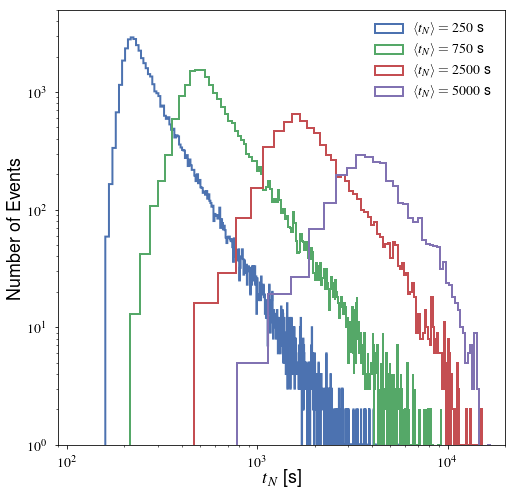

In [8]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
for freq in [250,750,2500,5000]:
    ax.hist(event_wait_times['{}'.format(freq)],
            log=True,bins='fd',histtype='step',lw=2,
            label=r'$\langle t_N\rangle={}$ s'.format(freq))
ax.set_xscale('log')
ax.set_ylim([1,5e3])
ax.set_xlim([9e1,2e4])
ax.set_xlabel(r'$t_N$ [s]')
ax.set_ylabel(r'Number of Events')
leg = ax.legend(loc=1,frameon=False)
fig.savefig('../figures/wait_time_distributions.pdf',dpi=1000)

## Spectroscopic Details

## Emission Measure Distributions

## Emission Measure Slopes

## Slope Distributions